In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from sklearn.linear_model import LinearRegression

import analysis_utils as aute

In [2]:
rdm_th = 0
corr_th = 0.85

In [3]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".xlsx" in file][0]
    df_x = pd.read_excel(path_to_conversations + conv + "/" + excel_name)
    if df_x.shape[0] > 2:
        all_df_list.append(df_x)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 157


In [4]:
def include_time_columns(data, col_name):
    
    return {
        "Mean_" + col_name: np.nanmean(data[col_name]) if col_name in data.columns else np.nan,
        "Max_" + col_name: np.nanmax(data[col_name]) if col_name in data.columns else np.nan,
        "Min_" + col_name: np.nanmin(data[col_name]) if col_name in data.columns else np.nan,
        "Diff_" + col_name: (
            data[col_name].dropna().iloc[-1] - data[col_name].dropna().iloc[0] if col_name in data.columns else np.nan
        ),
    }

In [5]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["UnixTimestampEnd"].iloc[-1] - df["UnixTimestampInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, "OpenAItime_s")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, "AWStime_s")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, "S2Ttime_s")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 12.5478 +/- 7.9484 ; Median = 12.0 ; Min. =  3 ; Max. =  42



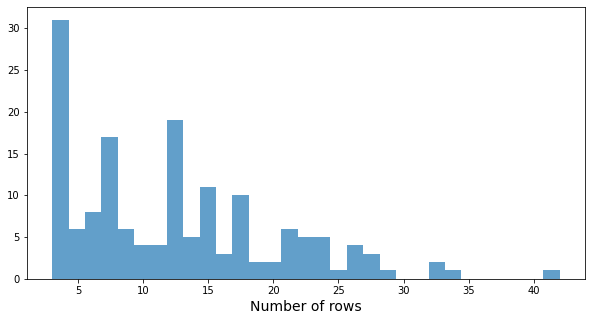

Mean Number of cols = 11.5924 +/- 1.2965 ; Median = 12.0 ; Min. =  10 ; Max. =  15

Mean Time conversation (min) = 1.7765 +/- 1.3538 ; Median = 1.6579 ; Min. =  0.1264 ; Max. =  6.5459



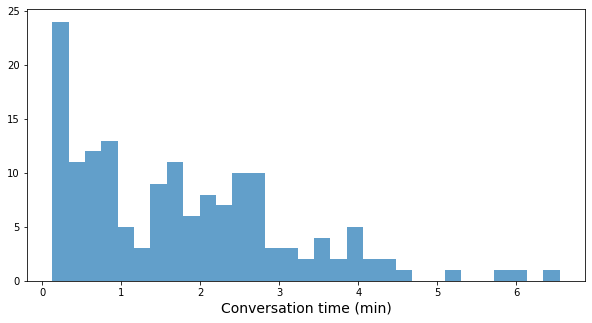

In [6]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.5667 +/- 0.4585 ; Median = 1.4563 ; Min. =  1.1417 ; Max. =  2.9512
Mean Mean_AWStime_s = 0.1063 +/- 0.0218 ; Median = 0.0985 ; Min. =  0.0896 ; Max. =  0.1758
Mean Mean_S2Ttime_s = 1.4522 +/- 0.1959 ; Median = 1.4205 ; Min. =  1.211 ; Max. =  1.8843


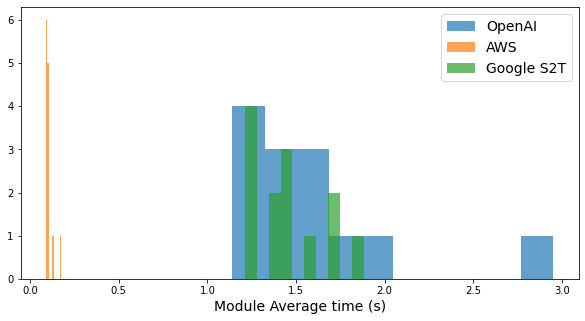

In [7]:
aute.stat_print(df_check["Mean_OpenAItime_s"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWStime_s"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_S2Ttime_s"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAItime_s"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWStime_s"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_S2Ttime_s"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.6036 +/- 1.3816 ; Median = 1.2907 ; Min. =  0.474 ; Max. =  5.9023
Mean Mean_AWStime_s = -0.2345 +/- 0.02 ; Median = -0.2331 ; Min. =  -0.2778 ; Max. =  -0.2042
Mean Mean_S2Ttime_s = 0.527 +/- 0.3062 ; Median = 0.4357 ; Min. =  -0.076 ; Max. =  1.0048


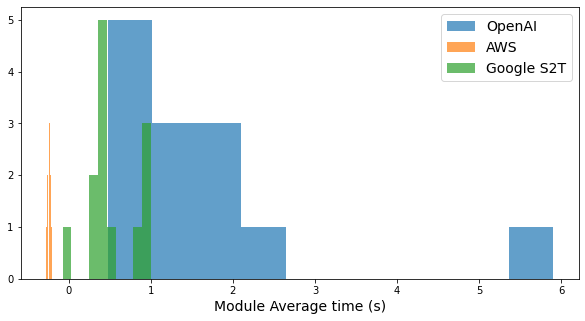

In [8]:
aute.stat_print(df_check["Diff_OpenAItime_s"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Diff_AWStime_s"], "Mean_AWStime_s")
aute.stat_print(df_check["Diff_S2Ttime_s"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Diff_OpenAItime_s"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Diff_AWStime_s"], alpha=0.7, label="AWS")
plt.hist(df_check["Diff_S2Ttime_s"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

In [35]:
save_time_dict = {
    "AWS_t": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "Google_S2T": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "OpenAI": {
        "num_words": [],
        "num_characters": [],
        "time": []
    }
}
for df in all_df_list:
    if "AWStime_s" in df.columns:
        for i in range(df.shape[0] // 2):
            bot_sentence = df[df["Source"]=="Bot"]["SpanishMessage"].iloc[i]
            num_all_words = len( "".join(re.findall(r'\w+', bot_sentence)) )
            save_time_dict["AWS_t"]["num_words"].append( num_all_words )
            save_time_dict["AWS_t"]["num_characters"].append( len(bot_sentence) )
            save_time_dict["AWS_t"]["time"].append( df[df["Source"]=="Person"]["AWStime_s"].iloc[i] )
    
    if "S2Ttime_s" in df.columns:
        df_person = df[df["Source"]=="Person"]
        for i in range(df_person.shape[0]):
            num_all_words = len( "".join(re.findall(r'\w+', df_person["SpanishMessage"].iloc[i])) )
            save_time_dict["Google_S2T"]["num_words"].append( num_all_words )
            save_time_dict["Google_S2T"]["num_characters"].append( len(df_person["SpanishMessage"].iloc[i]) )
            save_time_dict["Google_S2T"]["time"].append( df_person["S2Ttime_s"].iloc[i] )

    if "OpenAItime_s" in df.columns:
        df_bot = df[df["Source"]=="Bot"]
        for i in range(df_bot.shape[0]):
            num_all_words = len( "".join(re.findall(r'\w+', df_bot["GlobalMessage"].iloc[i])) )
            save_time_dict["OpenAI"]["num_words"].append( num_all_words )
            save_time_dict["OpenAI"]["num_characters"].append( len(df_bot["GlobalMessage"].iloc[i]) )
            save_time_dict["OpenAI"]["time"].append( df_bot["OpenAItime_s"].iloc[i] )


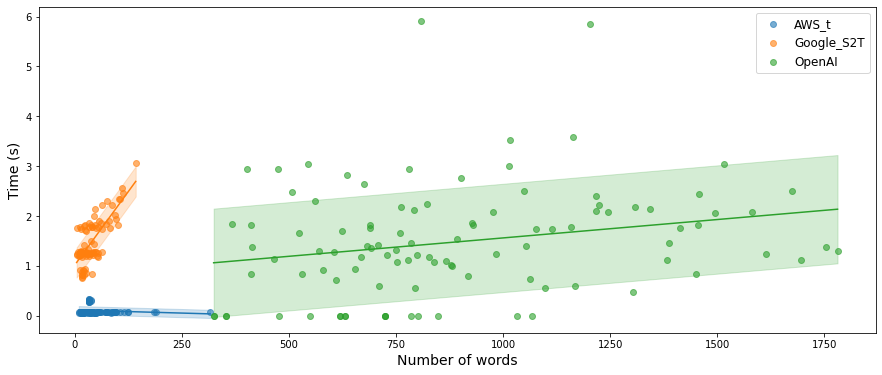

In [36]:
plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):

    sort_x_idx = np.argsort(v["num_words"])
    y_time = np.array(v["time"])[sort_x_idx]
    x_len_text = np.array(v["num_words"])[sort_x_idx]

    x_to_lr = np.array(x_len_text).reshape(-1, 1)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_to_lr, y_time)
    y_pred = lr.predict(x_to_lr)

    err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
    y_time_plus = y_pred + err_pred
    y_time_minus = y_pred - err_pred


    plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
    plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
    plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])


plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

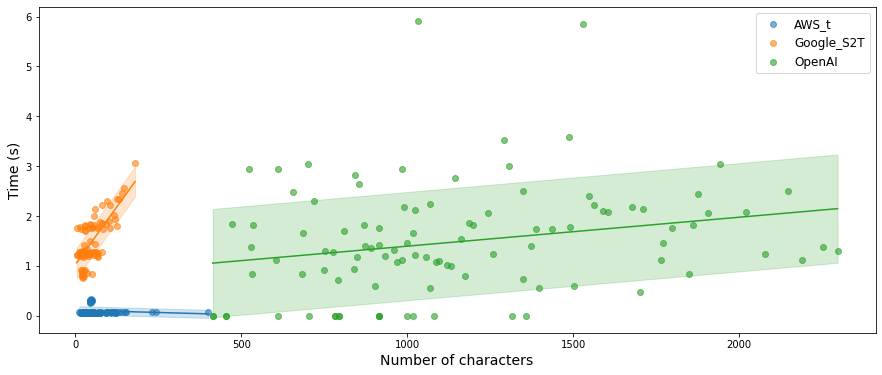

In [37]:
plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):

    sort_x_idx = np.argsort(v["num_characters"])
    y_time = np.array(v["time"])[sort_x_idx]
    x_len_text = np.array(v["num_characters"])[sort_x_idx]

    x_to_lr = np.array(x_len_text).reshape(-1, 1)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_to_lr, y_time)
    y_pred = lr.predict(x_to_lr)

    err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
    y_time_plus = y_pred + err_pred
    y_time_minus = y_pred - err_pred


    plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
    plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
    plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of characters", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

In [67]:
resource_name_list = ["OpenAItime_s", "AWStime_s", "S2Ttime_s"]
save_time_list = []
for df in all_df_list:
    for col in resource_name_list:
        if col in df.columns:
            for t in df.iloc[1:][col].dropna():
                save_time_list.append({
                    "Source": col,
                    "Time": t
                })

    if "OpenAItime_s" in df.columns:
        n_pairs = df.shape[0] // 2
        for i in range(n_pairs):
            begin_iteration = df["UnixTimestampInit"].iloc[2*i]
            end_iteration = df["UnixTimestampEnd"].iloc[2*i+1]

            save_time_list.append({
                "Source": "Total",
                "Time": end_iteration - begin_iteration
            })

            all_resources = np.nansum(df.iloc[(2*i):(2*i+1+1)][resource_name_list].values)

            save_time_list.append({
                "Source": "Rest",
                "Time": (end_iteration - begin_iteration) - all_resources
            })
        
df_times = pd.DataFrame(save_time_list)
print("Shape", df_times.shape)

Shape (454, 2)


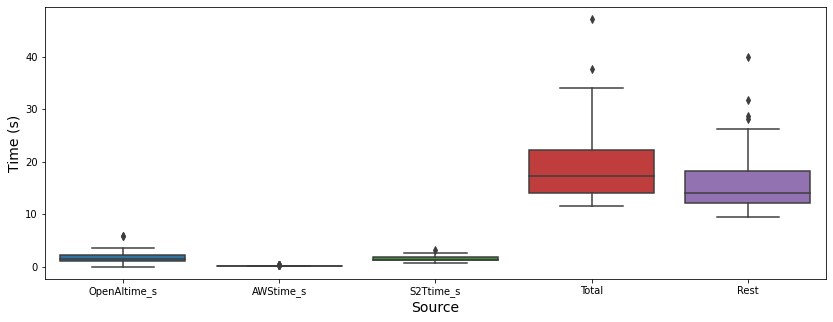

In [68]:
plt.figure(figsize=(14, 5))
sns.boxplot(x="Source", y="Time", data=df_times)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()